In [24]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }a
</style>
"""))

# Libraries

In [25]:
import numpy as np
import chardet
import matplotlib.patches as mpatches
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import folium as fm
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap, StripePattern
from IPython.display import IFrame

# Reading, handling and processing IPRESS.csv

In [26]:
base = open('../data/IPRESS.csv', 'rb').read()
det = chardet.detect(base)
charenc = det['encoding']
charencbase = open('../data/IPRESS.csv', 'rb').read()
det = chardet.detect(base)
charenc = det['encoding']
charenc

'MacRoman'

In [59]:
csv_data = pd.read_csv('../data/IPRESS.csv', encoding=charenc)
csv_data = csv_data.rename(columns={
    'InstituciÛn':'INSTITUCIÓN',
    'Nombre del establecimiento': 'NOMBRE DEL ESTABLECIMIENTO',
    'ClasificaciÛn':'CLASIFICACION',
    'Departamento':'DEPARTAMENTO',
    'Provincia':'PROVINCIA',
    'Distrito':'DISTRITO',
    'Estado':'ESTADO',
    'NORTE':'LATITUD',
    'ESTE':'LONGITUD'
})

In [60]:
cleaned_csv = csv_data.loc[csv_data['ESTADO'] == 'ACTIVADO'].dropna(subset=['LATITUD', 'LONGITUD'])

In [61]:
publicos_op = cleaned_csv.loc[
    (cleaned_csv['INSTITUCIÓN'].ne('PRIVADO')) &
    (cleaned_csv['INSTITUCIÓN'].ne('OTRO')) &
    (cleaned_csv['CondiciÛn'].eq('EN FUNCIONAMIENTO'))
].copy()

publicos_op['DISTRITO'] = publicos_op['DISTRITO'].str.strip().str.upper()


In [62]:
conteo_ubigeo = (
    publicos_op.groupby('UBIGEO')
    .size()
    .reset_index(name='CANTIDAD')
)

# Distritos Shape file 

In [31]:
maps = gpd.read_file('../data/distritos/DISTRITOS.shp')[['IDDIST', 'geometry']]
maps = maps.rename(columns={'IDDIST':'UBIGEO'})
maps['UBIGEO'] = maps['UBIGEO'].astype(str).astype(int)
maps = maps.to_crs(epsg=4326)

#### Merged data

In [32]:
distritos = maps.merge(conteo_ubigeo, on='UBIGEO', how='left')
distritos['CANTIDAD'] = distritos['CANTIDAD'].fillna(0).astype(int)

# Task 1: Static maps: count of hospitals by district

#### Map 1: Total public hospitals per district.

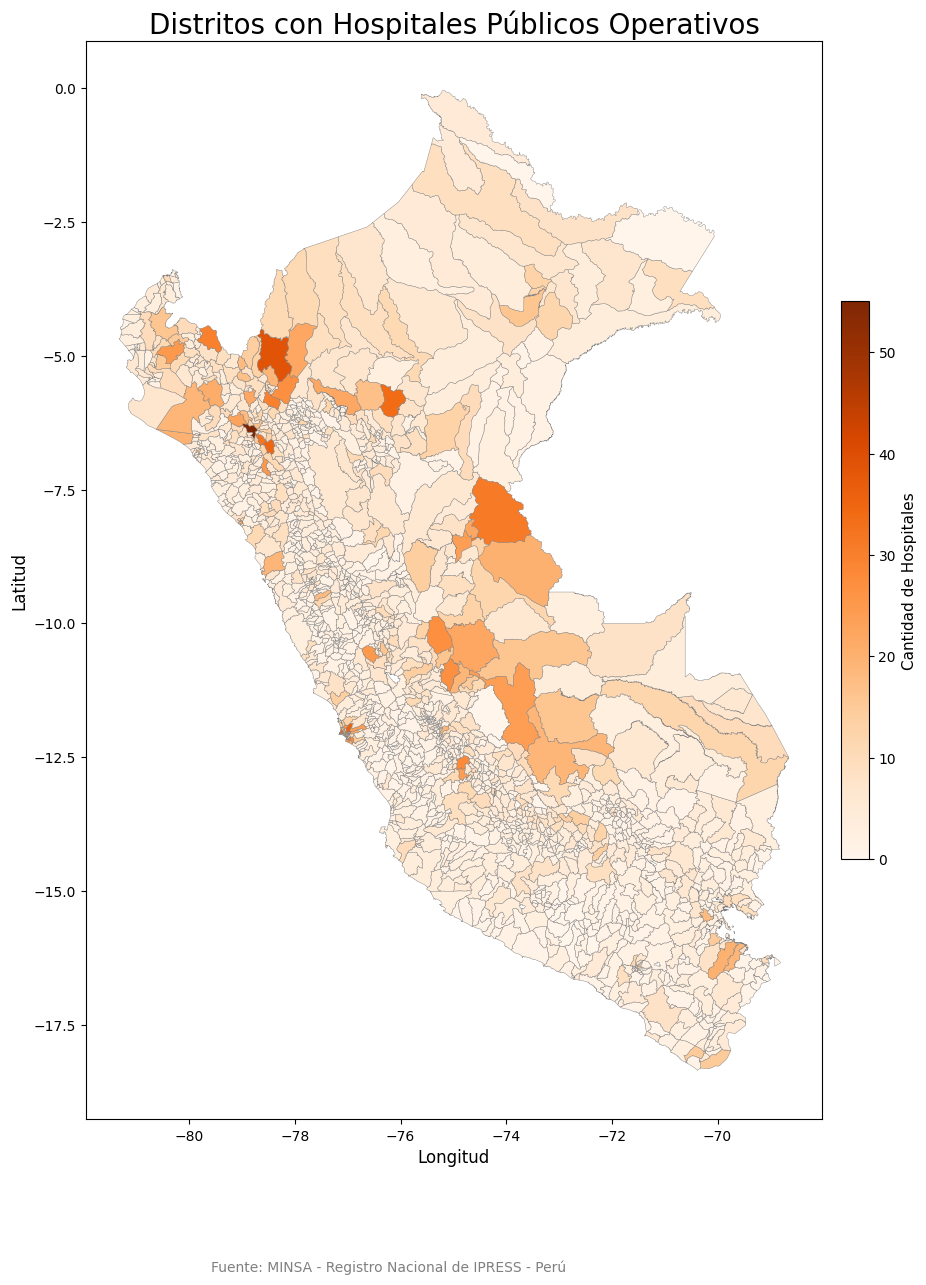

In [34]:
fig, ax = plt.subplots(figsize=(12, 14))

distritos.plot(
    column='CANTIDAD',
    cmap='Oranges',
    linewidth=0.3,
    edgecolor='gray',
    legend=False,
    ax=ax
)

ax.set_title('Distritos con Hospitales Públicos Operativos', fontsize=20)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

norm = colors.Normalize(vmin=distritos['CANTIDAD'].min(), vmax=distritos['CANTIDAD'].max())
sm = cm.ScalarMappable(cmap='Oranges', norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('Cantidad de Hospitales', fontsize=11)

fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")


fig.savefig('../output/map_1.png', dpi=300, bbox_inches='tight')
plt.show()

#### Map 2: Highlight districts with zero hospitals

/var/folders/2w/49y_fhrn5hx6ld44gwry6v680000gn/T/ipykernel_39596/718898812.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/var/folders/2w/49y_fhrn5hx6ld44gwry6v680000gn/T/ipykernel_39596/718898812.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower left')


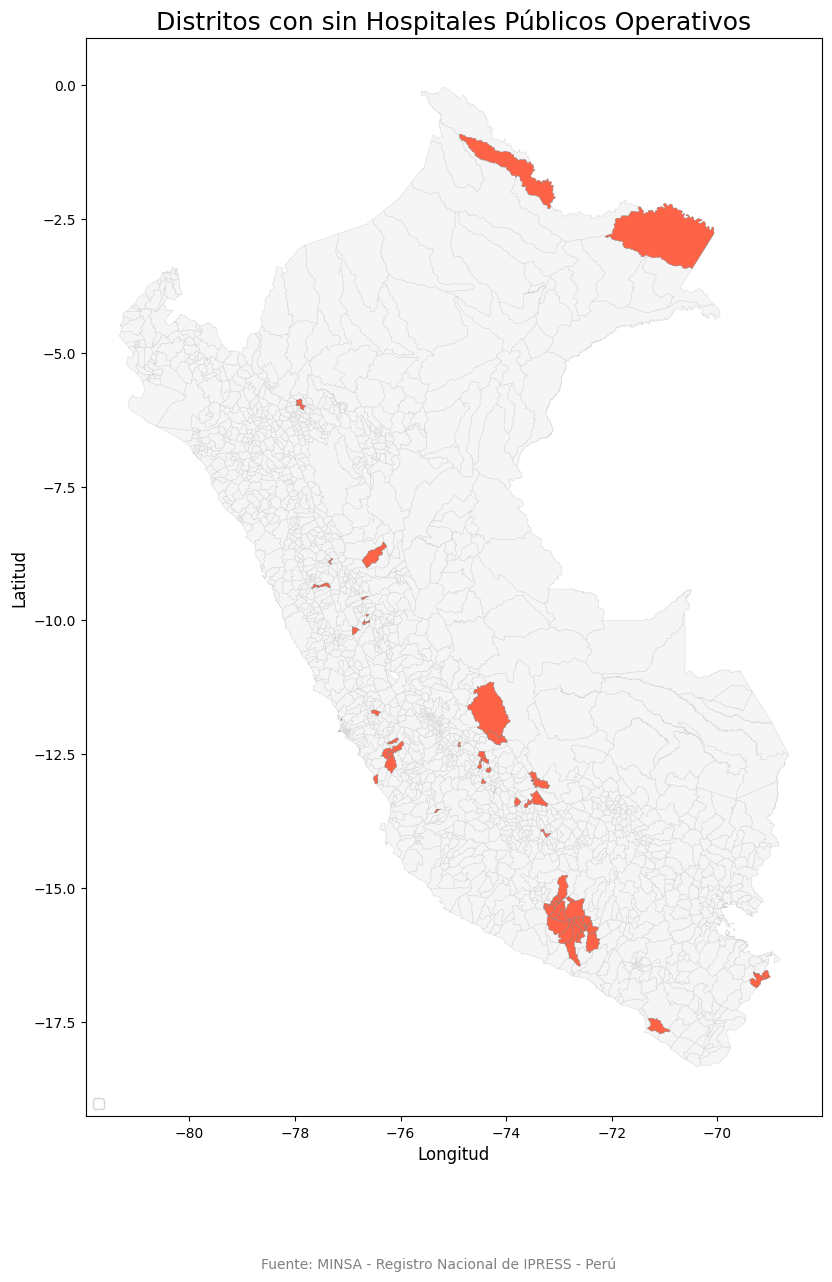

In [35]:
distritos['HOSPITALES'] = (distritos['CANTIDAD'] > 0).map({True: 'Con hospitales', False: 'Sin hospitales'})

fig, ax = plt.subplots(figsize=(12, 14))


distritos.plot(ax=ax, color='whitesmoke', edgecolor='lightgray', linewidth=0.3)


distritos.loc[distritos['CANTIDAD'].eq(0)].plot(
    ax=ax, color='tomato', edgecolor='gray', linewidth=0.3, label='Sin hospitales'
)

ax.legend(loc='lower left')
ax.set_title('Distritos con sin Hospitales Públicos Operativos', fontsize=18)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")

fig.savefig('../output/map_2.png', dpi=300, bbox_inches='tight')
plt.show()

#### Map 3: Top 10 districts with the highest number of hospitals (distinct color scale).

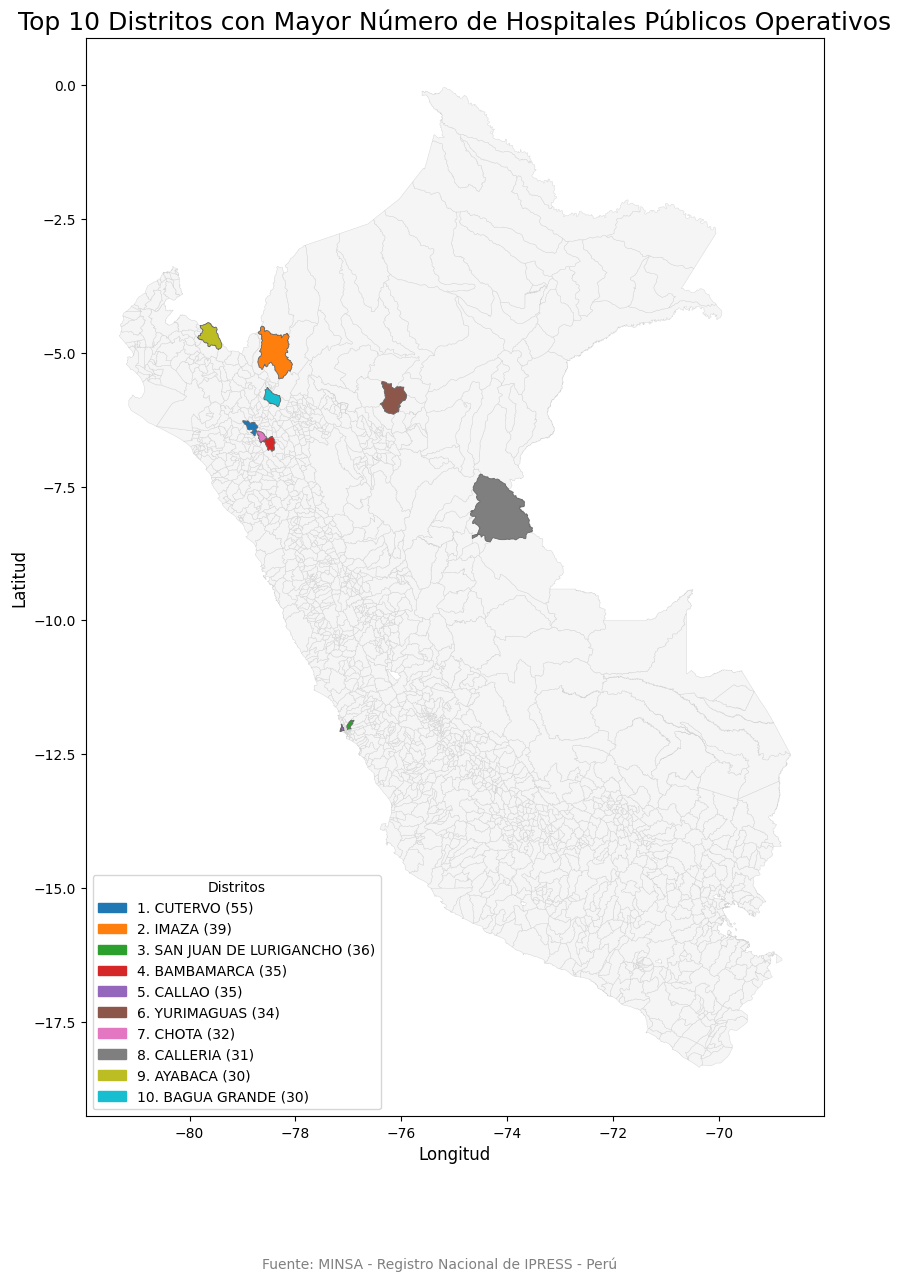

In [36]:
if 'DISTRITO' not in distritos.columns:
    nombres = (cleaned_csv[['UBIGEO', 'DISTRITO']]
               .dropna(subset=['UBIGEO', 'DISTRITO'])
               .drop_duplicates('UBIGEO')
               .copy())
    nombres['DISTRITO'] = nombres['DISTRITO'].str.strip().str.upper()
    distritos = distritos.merge(nombres, on='UBIGEO', how='left')


top10 = distritos.sort_values('CANTIDAD', ascending=False).head(10).copy()
top10['RANK'] = np.arange(1, len(top10) + 1)


fig, ax = plt.subplots(figsize=(12, 14))
distritos.plot(ax=ax, color='whitesmoke', edgecolor='lightgray', linewidth=0.3)


cmap = plt.get_cmap('tab10')
top10.plot(
    ax=ax,
    column='RANK',
    categorical=True,
    cmap=cmap,
    linewidth=0.6,
    edgecolor='dimgray'
)


handles = []
for _, row in top10.iterrows():
    color = cmap((row['RANK'] - 1) % 10)
    nombre = row.get('DISTRITO', f"UBIGEO {row['UBIGEO']}")
    label = f"{int(row['RANK'])}. {nombre} ({int(row['CANTIDAD'])})"
    handles.append(mpatches.Patch(color=color, label=label))
ax.legend(handles=handles, title="Distritos", loc='lower left', frameon=True)

ax.set_title('Top 10 Distritos con Mayor Número de Hospitales Públicos Operativos', fontsize=18)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)
fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")

fig.savefig('../output/map_3.png', dpi=300, bbox_inches='tight')
plt.show()

# Task 2: Department-level Analysis

#### A summary table (sorted from highest to lowest).

In [37]:
dept_counts = (
    publicos_op.groupby('DEPARTAMENTO')
    .size()
    .reset_index(name='TOTAL_HOSPITALES')
    .sort_values('TOTAL_HOSPITALES', ascending=False)
)
max_dept = dept_counts.iloc[0]
min_dept = dept_counts.iloc[-1]
dept_counts.to_csv("../output/operationao_hospitals_by_department.csv", index=False, encoding="utf-8")

In [38]:
display(dept_counts)
print(f"Departamento con mas hospitales: {max_dept['DEPARTAMENTO']} ({max_dept['TOTAL_HOSPITALES']})")
print(f"Departamento con men hospitales: {min_dept['DEPARTAMENTO']} ({min_dept['TOTAL_HOSPITALES']})")

,DEPARTAMENTO,TOTAL_HOSPITALES
5,CAJAMARCA,840
14,LIMA,751
11,JUNIN,487
19,PIURA,426
1,ANCASH,413
20,PUNO,405
0,AMAZONAS,400
4,AYACUCHO,386
2,APURIMAC,374
21,SAN MARTIN,373


Departamento con mas hospitales: CAJAMARCA (840)
Departamento con men hospitales: TUMBES (51)


#### A bar chart 

/var/folders/2w/49y_fhrn5hx6ld44gwry6v680000gn/T/ipykernel_39596/1407907244.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


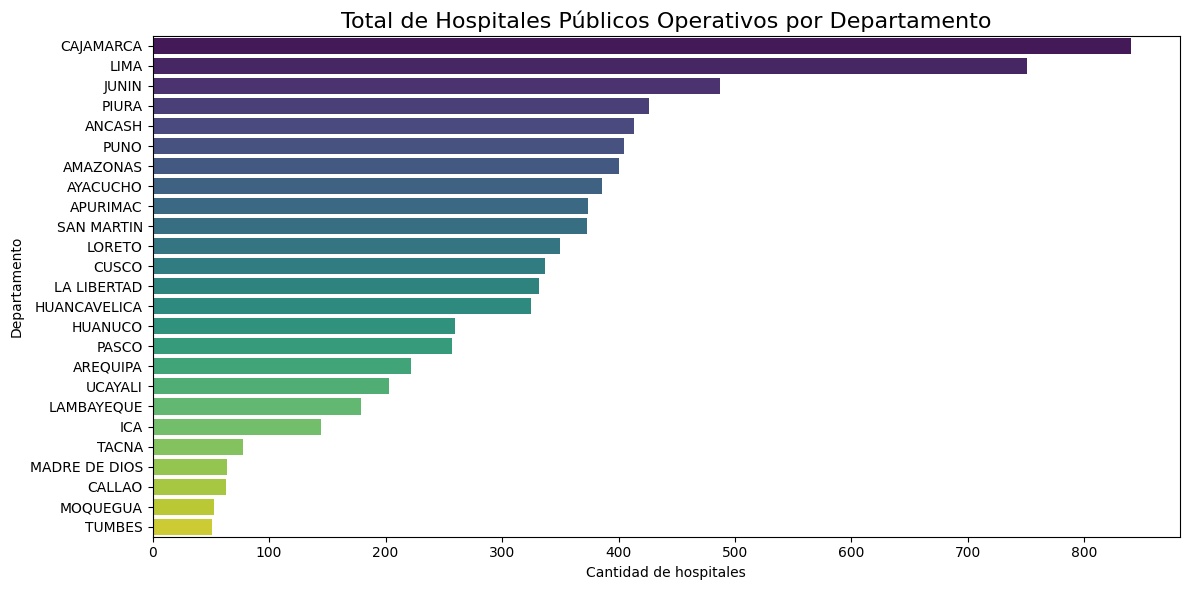

In [39]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=dept_counts,
    x='TOTAL_HOSPITALES',
    y='DEPARTAMENTO',
    palette='viridis'
)
plt.title("Total de Hospitales Públicos Operativos por Departamento", fontsize=16)
plt.xlabel("Cantidad de hospitales")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

fig.savefig('../output/map_bar_chart.png', dpi=300, bbox_inches='tight')

#### A department-level choropleth map (GeoPandas)

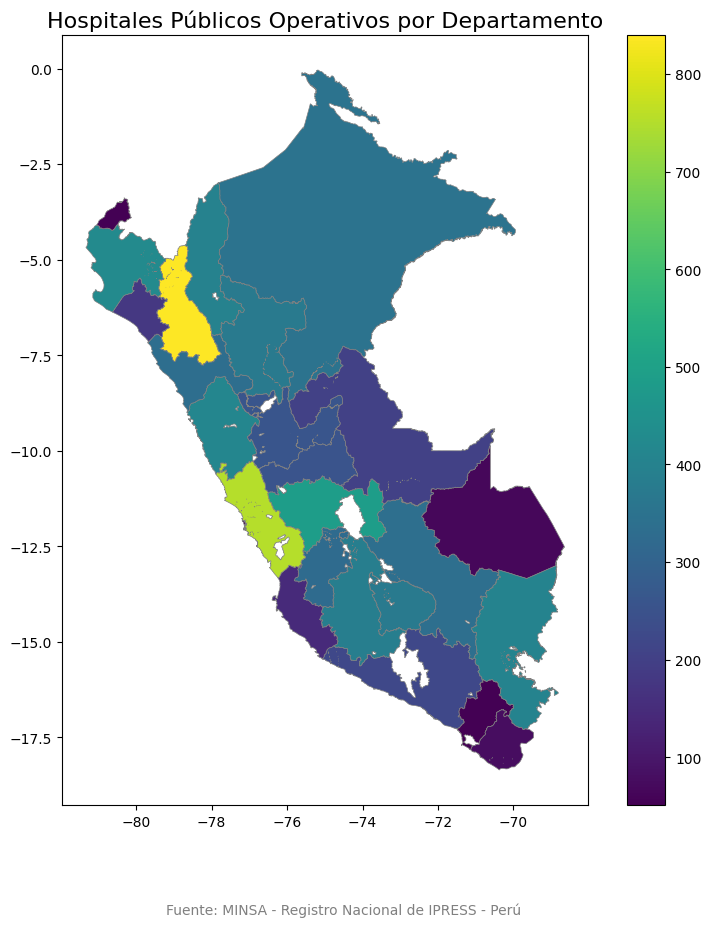

In [40]:

dept_drop_dup = publicos_op[['UBIGEO', 'DEPARTAMENTO']].drop_duplicates()

maps_dept = maps.merge(dept_drop_dup, on='UBIGEO', how='left')

departamentos_shp = maps_dept.dissolve(by='DEPARTAMENTO', as_index=False)


departamentos_shp['DEPARTAMENTO'] = departamentos_shp['DEPARTAMENTO'].str.strip().str.upper()
dept_counts['DEPARTAMENTO'] = dept_counts['DEPARTAMENTO'].str.strip().str.upper()


dept_map = departamentos_shp.merge(dept_counts, on='DEPARTAMENTO', how='left')
dept_map['TOTAL_HOSPITALES'] = dept_map['TOTAL_HOSPITALES'].fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(10,10))
dept_map.plot(
    column='TOTAL_HOSPITALES',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title("Hospitales Públicos Operativos por Departamento", fontsize=16)
fig.text(0.5, 0.001, "Fuente: MINSA - Registro Nacional de IPRESS - Perú",
         ha="center", fontsize=10, color="gray")

fig.savefig('../output/map_department_level_choropleth_map.png', dpi=300, bbox_inches='tight')
plt.show()



# Task 3: Proximity Analysis (using Population Centers)

##### Getting the centroid

In [41]:
pop_center = gpd.read_file('../data/CCPP_0/CCPP_IGN100K.shp')
pop_center.rename(columns={'X':'LONGITUD', 'Y':'LATITUD'}, inplace=True)
pop_center.head()


,OBJECTID,NOM_POBLAD,FUENTE,CÓDIGO,CAT_POBLAD,DIST,PROV,DEP,CÓD_INT,CATEGORIA,LONGITUD,LATITUD,N_BUSQDA,geometry
0,1,PANDISHARI,INEI,2502010002,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.06462,-10.37129,PANDISHARI,POINT (-74.06462 -10.37129)
1,2,CHICOSA,INEI,2502010003,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.06153,-10.37852,CHICOSA,POINT (-74.06153 -10.37852)
2,3,RAYA,IGN,2502010004,OTROS,RAYMONDI,ATALAYA,UCAYALI,2350,Centro Poblado Menor,-72.94118,-10.33043,RAYA,POINT (-72.94118 -10.33043)
3,4,PENSILVANIA,INEI,2502010005,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.05988,-10.40401,PENSILVANIA,POINT (-74.05988 -10.40401)
4,5,PONTE VEDRA,INEI,2502010006,CASERÍO,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.03788,-10.41809,PONTE VEDRA,POINT (-74.03787 -10.41809)


In [42]:
def get_centroid(dep):
    
    sub = pop_center.loc[pop_center['DEP'] == dep]
    lon = sub.geometry.x.mean()
    lat = sub.geometry.y.mean()
    
    return lat, lon

#### Making sure the data is in EPSG4326

In [54]:
pop_center.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# void

# 3- Interactive Mapping with Folium

In [72]:
dept_map



,DEPARTAMENTO,geometry,UBIGEO,TOTAL_HOSPITALES
0,AMAZONAS,"POLYGON ((-78.03480 -6.74216, -78.03437 -6.741...",10103,400
1,ANCASH,"POLYGON ((-77.70189 -10.32392, -77.70434 -10.3...",21805,413
2,APURIMAC,"POLYGON ((-73.51174 -14.53852, -73.51368 -14.5...",30607,374
3,AREQUIPA,"POLYGON ((-72.18562 -16.92467, -72.18593 -16.9...",40706,222
4,AYACUCHO,"POLYGON ((-74.50284 -15.16064, -74.50360 -15.1...",50404,386
5,CAJAMARCA,"POLYGON ((-79.07326 -7.46865, -79.08528 -7.462...",60505,840
6,CALLAO,"POLYGON ((-77.10504 -12.07191, -77.10599 -12.0...",70104,63
7,CUSCO,"POLYGON ((-71.89418 -14.78954, -71.89579 -14.7...",80805,337
8,HUANCAVELICA,"POLYGON ((-75.26012 -14.04196, -75.26102 -14.0...",90613,325
9,HUANUCO,"POLYGON ((-76.80833 -10.39296, -76.81024 -10.3...",100902,260


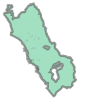

In [73]:
dept_map['geometry'][14]